In [2]:
%reload_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Outline

- Background
    - Gaussian Mixture Models
    - Hidden Markov Models
- Programming by Demonstration
    - Approach
    - Benefits & Drawbacks
    - Code
    - Results
    

## Background
### Gaussian Mixture Models

- method for clustering data
- generative probabilistic model of the data
- $K$ different Gaussians with parameters $\mu_k$, $\Sigma_k$
- $P(c_i = k) = \pi_k$
- $P(x_i|c_i = k; \mu_k, \Sigma_k) = \mathcal{N}(x_i | \mu_k, \Sigma_k)$
- Expectation Maximization Algorithm:
    - initialize randomly
    - E-step: (soft-assignment)
    $$q(c_i = k) = P(c_i = k | x_i, \mu_{1;K}, \Sigma_{1:K}) \propto  \mathcal{N}(x_i | \mu_k, \Sigma_k) \pi_k$$
    - M-step: update parameters
    $$\pi_k = \frac{1}{n}\sum_i q(c_i = k)$$
    $$\mu_k = \frac{1}{n \pi_k} \sum_i q(c_i = k) x_i$$
    $$\Sigma_K = \frac{1}{n\pi_k} \sum_i q(ci=k) x_i x_i^T -\mu_k\mu_k^T$$

(https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/19-MachineLearning/06-unsupervised.pdf)

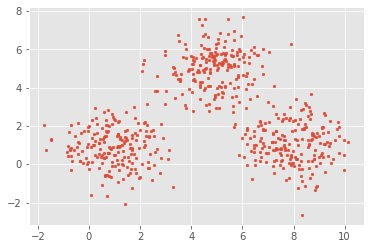

In [4]:
center_1 = np.array([1,1])
center_2 = np.array([5,5])
center_3 = np.array([8,1])

# Generate random data and center it to the three centers
data_1 = np.random.randn(200, 2) + center_1
data_2 = np.random.randn(200,2) + center_2
data_3 = np.random.randn(200,2) + center_3

data = np.concatenate((data_1, data_2, data_3), axis = 0)

plt.scatter(data[:,0], data[:,1], s=7)

### k - means clustering
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

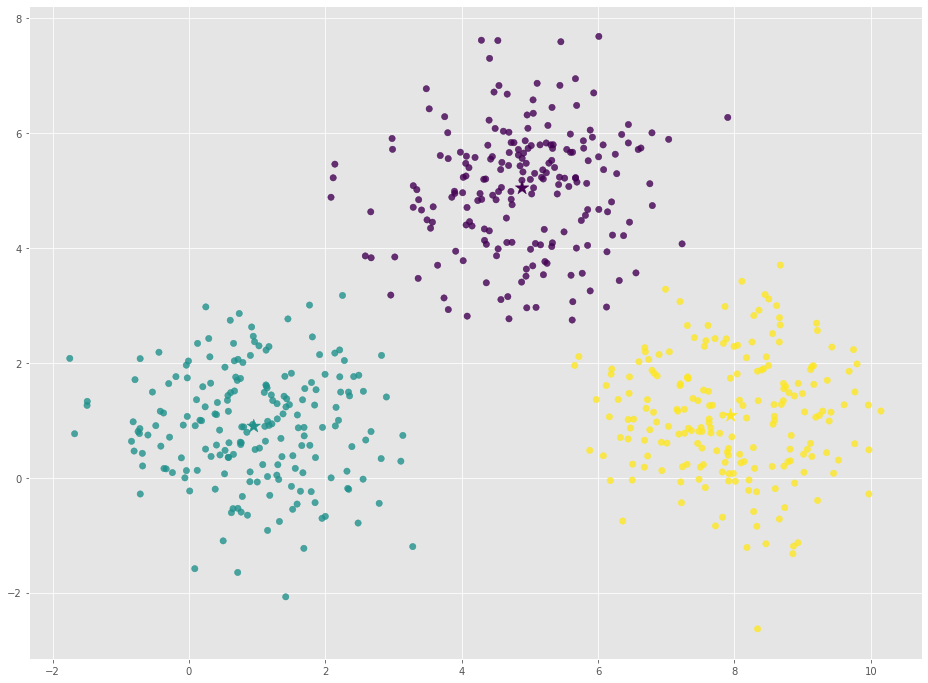

In [5]:
from sklearn.cluster import KMeans

def plot_kmeans_model(n_clusters=3, max_iter=10):
    model = KMeans(n_clusters=n_clusters, max_iter=max_iter)
    model.fit(data)
    y = model.predict(data)
    plt.figure(figsize=(16,12))
    plt.scatter(data[:, 0], data[:, 1], c=y, s=40, alpha=0.8)
    centers = model.cluster_centers_
    y_centers = model.predict(centers)
    plt.scatter(centers[:, 0], centers[:, 1], c=y_centers, s=200, marker="*")


plot_kmeans_model()

### Gaussian Mixture Model
https://scikit-learn.org/stable/modules/mixture.html

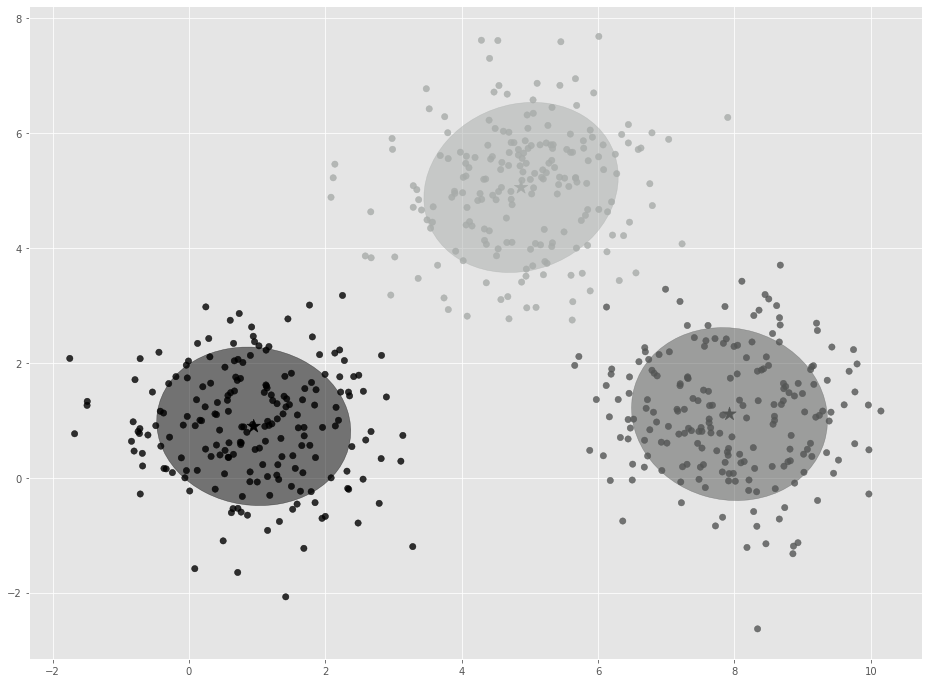

In [6]:
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
from matplotlib import colors as mcolors

def get_spaced_colors(n, opacity=1):
    max_value = 16581375 #255**3
    interval = int(max_value/ n )
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    return [(int(i[:2], 16)/255, int(i[2:4], 16)/255, int(i[4:], 16)/255, opacity) for i in colors]

def plot_gmm(n_clusters=3, max_iter=10):
    colors = get_spaced_colors(n_clusters)
    model = GaussianMixture(n_components=n_clusters, max_iter=max_iter)
    model.fit(data)
    y = model.predict(data)
    fig, ax = plt.subplots(figsize=(16,12))
    colors_y = list(map(lambda x: colors[x], y))
    plt.scatter(data[:, 0], data[:, 1], c=colors_y, s=40, alpha=0.8)
    centers = model.means_
    y_centers = model.predict(centers)
    colors_c = list(map(lambda x: colors[x], y_centers))
    plt.scatter(centers[:, 0], centers[:, 1], c=colors_c, s=200, marker="*")
    for i, (mean, covar) in enumerate(list(zip(model.means_, model.covariances_))):
        v, w = np.linalg.eigh(covar)
        v = 2* np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        angle =  180. * np.arctan(u[1]/u[0]) / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=colors_c[i])
        ell.set_clip_box(fig.bbox)
        ell.set_alpha(0.5)
        ax.add_patch(ell)
        

plot_gmm(n_clusters=3, max_iter=100)

### Hidden Markov Models

- joint distribution 

$$P(X_{0:T}, Y_{0:T}) = P(X_0) \cdot \prod_{t=1}^T P(X_{t}| X_{t-1}) \cdot \prod_{t=0}^T P(Y_{t}| X_{t})$$

https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/18-ArtificialIntelligence/10-dynamicalModels.pdf

In [7]:
import hmms
import pbdlib as pbd
import pickle
import os
from collections import defaultdict
os.getcwd()

'/home/marc/git/uni/imitation-learning/slides'

In [8]:
# load names of joints to map from ros 2 rai joints. Only relevant joints (of right arm) are loaded
with open('../bagfiles/names.pkl', 'rb') as f:
    names = pickle.load(f)

# load demonstration dataset type: List of np.array() with shape=(np_steps_in_trajectory, 2*dim(q))
with open('../bagfiles/dataset.pkl', 'rb') as f:
    demos = pickle.load(f)

In [26]:
# initialize HMM model and train using expectation-maximization (already implemented in https://gitlab.idiap.ch/rli/pbdlib-python)
model = pbd.HMM(7, 14)
model.init_hmm_kbins(demos)
model.em(demos, obs_fixed=True, left_to_right=False)

EM converges


True

Unfortunately, some functions for reproducing the demonstrated tasks were missing from the framework. So I added them. (I assume, the framework was made specifically for more recent papers.)

Predicting the next joint velocities to fulfill the task, given current joint angles:

$$\hat{\dot{x}} = \sum_{i=1}^K h_i(x) [ \mu_i^{\dot{x}} + \Sigma_i^{\dot{x}x}(\Sigma_i^x)^{-1} (x - \mu_i^x)]$$

In [10]:
from pbdlib.functions import multi_variate_normal
from types import MethodType

# add datastructure to save previously computed values (prediction almost impossible without doing this)
model.qs = {}
model.hs = {}

# add missing function for q_dot prediction, given the trained hmm
def predict_qdot(self, q, t):
    q_dim = len(q)
    q_dot = np.zeros((q_dim))
    for i in range(self.nb_states):
        a = q - self.mu[i][0:q_dim]
        b = np.linalg.inv(self.sigma[i][0:q_dim , 0:q_dim]) @ a
        c = self.sigma[i][q_dim:, 0:q_dim] @ b
        d = self.mu[i][q_dim:] + c
        q_dot += self.h(i, q , t) * d
    return q_dot


def _normal_q(self, q, i):
    """
    Compute probability of q belonging to distribution i
    """
    q_dim = len(q)
    a = multi_variate_normal(q, self.mu[i][0:q_dim], sigma=self.sigma[i][0:q_dim, 0:q_dim])
    return a

# bind to class methods 
model.predict_qdot = MethodType(predict_qdot, model)
model._normal_q = MethodType(_normal_q, model)

Weighting history function for capturing sequential information:

$$h_i(x_t) = \frac{(\sum_{j=1}^K h_j(x_{t-1}) a_{ji}) \mathcal{N}(x_t; \mu_i^x, \Sigma_i^x)}{\sum_{k=1}^K [(\sum_{j=1}^K h_j(x_{t-1}) a_{jk})\mathcal{N}(x_t; \mu_k^x, \Sigma_k^x)]}$$

In [11]:
def h(self, i, q, t):
    if (i, t) in self.hs.keys():
        # if the value was already computed: take it!
        return self.hs[i, t]
    self.qs[t] = q
    if t == 0:
        s = 0
        for j in range(self.nb_states):
            s += self.priors[j] * self._normal_q(q, j)
        res = self.priors[i] * self._normal_q(q, i)
        res /= s
    else:
        num = 0
        for j in range(self.nb_states):
            num += self.h(j, self.qs[t-1], t-1) * self.Trans[j][i]
        num *= self._normal_q(q, i)
        denom = 0
        for k in range(self.nb_states):
            inner = 0
            for j in range(self.nb_states):
                inner += self.h(j, self.qs[t-1], t-1) * self.Trans[j][k]
            inner *= self._normal_q(q, k)
            denom += inner
        res = num / denom
    self.hs[i, t] = res
    return res

# bind to class methods 
model.h = MethodType(h, model)

Predicting the next joint angles, given current joint angles and predicted joint velocities:
$$\hat{x} = \sum_{i=1}^K h_i(x) [ \mu_i^{x} + \Sigma_i^{x\dot{x}}(\Sigma_i^\dot{x})^{-1} (\dot{x} - \mu_i^\dot{x})]$$

In [12]:
def predict_q(self, q_dot, q, t):
    q_dim = len(q_dot)
    q_new = np.zeros((q_dim))
    for i in range(self.nb_states):
        a = q_dot - self.mu[i][q_dim:]
        b = np.linalg.inv(self.sigma[i][q_dim: , q_dim:]) @ a
        c = self.sigma[i][:q_dim, q_dim:] @ b
        d = self.mu[i][:q_dim] + c
        # maybe q_dot instead of q in h; or maybe not
        q_new += self.h(i, q , t) * d
    return q_new

# bind to class methods 
model.predict_q = MethodType(predict_q, model)

In [13]:
import sys
# add the folder where libry.so is located to the path. Otherwise the import will crash.
sys.path.append('../../robotics-course/ry/')
import libry as ry
import time

In [14]:
# clear views, config and operate by setting shared pointers to 0. Otherwise the notebook has to be restarted,
# which is pretty annoying.
C = 0
v = 0
B = 0
    
# initialize config
C = ry.Config()
v = C.view()
C.clear()
C.addFile('../../robotics-course/rai-robotModels/baxter/baxter_new.g')

# add simulation. Note: if the string argument is not an empty string, a ROS node is started
# and the joint state topics of the real baxter are subscribed. This won't work if you can't connect to Baxter.
# In order to connect to Baxter, uncomment the next 2 lines and set the correct IP address:
#os.environ["ROS_MASTER_URI"] = "http://thecount.local:11311/"
#os.environ["ROS_IP"] = "<your-ip-address>"

B = C.operate('')
B.sync(C)
ik = C.komo_IK(False)
ik.setConfigurations(C)

q_home = C.getJointState()
right_joints = [name for name in C.getJointNames() if name.startswith('right')]

def get_joint_mapping():
    mapping = defaultdict(dict)
    print("RAI")
    for i, name in enumerate(C.getJointNames()):
        if name.startswith('right'):
            print("{} : {}".format(i, name))
            mapping[name]['rai'] = i
    print("ROS")
    i = 0
    for _, name in enumerate(names):
        if name.startswith('right'):
            print("{} : {}".format(i, name))
            mapping[name]['ros']=i
            i += 1
    return mapping

mapping = get_joint_mapping()

RAI
1 : right_s0
3 : right_s1
5 : right_e0
7 : right_e1
9 : right_w0
11 : right_w1
13 : right_w2
ROS
0 : right_e0
1 : right_e1
2 : right_s0
3 : right_s1
4 : right_w0
5 : right_w1
6 : right_w2


In [40]:
# directly setting joint velocities is not standard with to rai framework; playing around with the komo optimizer
def model_step_using_opt(t, kappa_p=0.1, kappa_v=0.1):
    B.sync(C)
    ik.setConfigurations(C)
    q_rai = C.getJointState()
    q = np.zeros((7, ))
    for name in right_joints:
        q[mapping[name]['ros']] = q_rai[mapping[name]['rai']]
    q_dot = model.predict_qdot(q, t)
    q_new = model.predict_q(q_dot, q, t)
    q_dot_rai = np.zeros((17,))
    for name in right_joints:
        q_rai[mapping[name]['rai']] = q_new[mapping[name]['ros']]
        q_dot_rai[mapping[name]['rai']] = q_dot[mapping[name]['ros']]
    ik.clearObjectives()
    ik.addObjective(feature=ry.FS.qItself, order=0, target=q_rai, type=ry.OT.eq, scale=[1])
    ik.addObjective(feature=ry.FS.qItself, order=1, target=q_dot_rai, type=ry.OT.eq, scale=[1])
    ik.optimize(False)
    C.setFrameState(ik.getConfiguration(0))
    q_rai = C.getJointState()
    B.move([q_rai], [1], True)
    return np.concatenate([q_new, q_dot])

# get velocity and new joint configuration from HMM-model, directly set joint configurations
def model_step(t):
    B.sync(C)
    q_rai = C.getJointState()
    q = np.zeros((7, ))
    for name in right_joints:
        q[mapping[name]['ros']] = q_rai[mapping[name]['rai']]
    q_dot = model.predict_qdot(q, t)
    q_new = model.predict_q(q_dot, q, t)
    for name in right_joints:
        q_rai[mapping[name]['rai']] = q_new[mapping[name]['ros']]
    B.move([q_rai], [1], False)
    return np.concatenate([q_new, q_dot])

def run_model(n_steps, ik=False):
    B.moveHard(q_home)
    C.setJointState(q_home)
    trajectory = []
    for i in range(n_steps):
        time.sleep(1)
        if ik:
            trajectory += [model_step_using_opt(i)]
        else:
            trajectory += [model_step(i)]
    return trajectory

def run_demo(demo):
    q_rai = np.zeros((17,))
    for i, qqdot in enumerate(demo):
        for name in right_joints:
            q_rai[mapping[name]['rai']] = qqdot[mapping[name]['ros']]
        time.sleep(1)
        B.move([q_rai], [0.1], True)

In [41]:
trajectory = run_model(7, True)

In [42]:
# PCA on demonstrations
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_trajectory(data):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(data[:, 0], data[:, 1], data[:, 2])   

pca_demo = PCA(3)
tfd_demo = pca_demo.fit_transform(demos[0])

pca_trajectory = PCA(3)
tfd_traj = pca_demo.transform(trajectory)


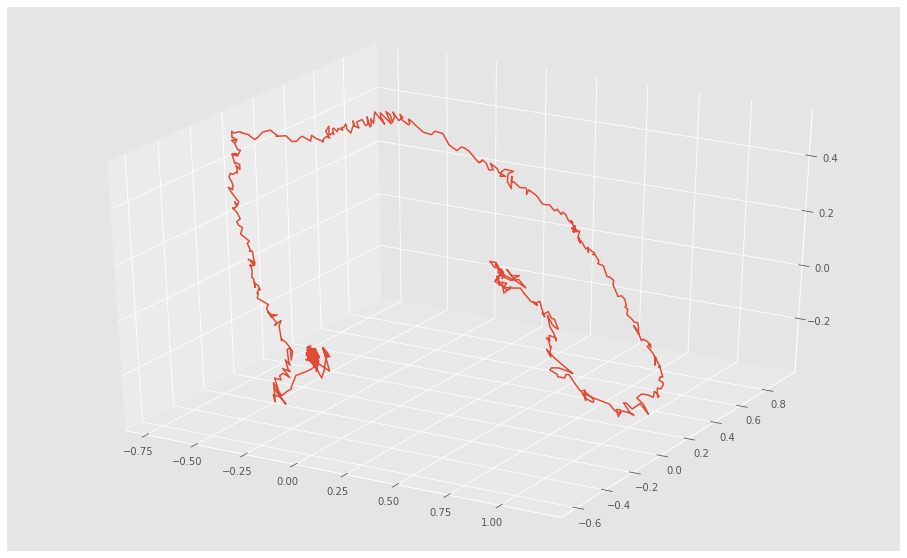

In [43]:
plot_3d_trajectory(tfd_demo)

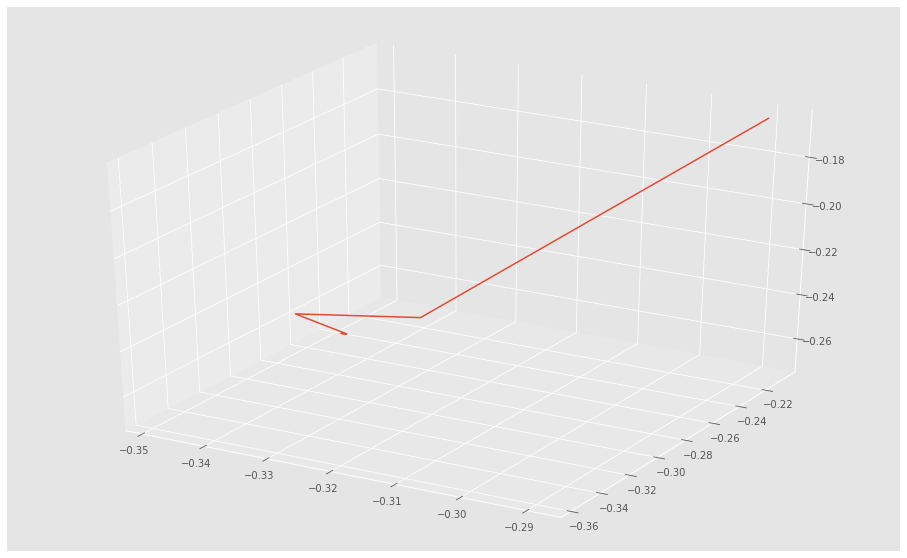

In [44]:
plot_3d_trajectory(tfd_traj)

# Outline

- GMM
    - kmeans + gmm(https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/19-MachineLearning/06-unsupervised.pdf)
    - kmeans implementation (https://www.kaggle.com/andyxie/k-means-clustering-implementation-in-python)
- HMM
    - hmm theoretical (https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/18-ArtificialIntelligence/09-graphicalModels.pdf)
    - hmm implementation heads + tails (https://github.com/ananthpn/pyhmm)
    - cont time and discrete time plots (https://github.com/lopatovsky/HMMs)
    - hmm robo filtering (https://github.com/beneisnr/hMm-filtering)
- DTW

- pbdlib
    - Related Work:
    - no symbolic approach (look up "Natural methods for robot task learning: Instructive demonstrations, generalization and practice")
        - DRAWBACK: symbolic approaches rely on biases to be segmented
    - no direct time dependence
        - DRAWBACK: Algining and scaling time dependet sequences is a difficult task (handling spatial and temporal perturbances is hard)
    - other approaches have considererd modeling the intrinsic dynamics of motion
        - BENEFIT: does not depent on explicit time variable
        - BENEFIT: can be modulated in unseen regions
        - DRAWBACK: require high number of states and smooting procedure
    - propsed model: HMMs and GMMs
    - GMR models joint probability function of the data (no direct regression like gpr)
    - regression function is then derived from the joint density model
        - ADVANTAGE: input and output components are only specified at the very last step of the process
        - ADVANTAGE: density estimation can be learning in an off-line phase, regression process can be computed very rapidly
        - ADVANTAGE: can handle different sources of missing data: system can consider any combination of input/output mappings

## Approach

- a skill is demonstrated to the robot in slightly different situations
- demonstration $m \in \{1, ..., M\}$ consists of a set of Trajectories $T_m$
- Trajectory $T_m$ consists of $d$-dimensional joint positions $x$ and velocities $\dot{x}$ 

$$D = \{\{(x_t, \dot{x}_t)\}_{t=1}^T\}_{m=1}^M$$

- joint distribution $\mathcal{P}(x, \dot{x})$ is encoded in a continuous HMM of K states.
- output distribution of each state is represented by a gaussian which encodes local variation and correlation information
- Parameters of HMM:

$$\{\Pi, a, \mu, \Sigma\}$$

- learned using Baum-Welch Algorithm(variant of the expectation maximization algorithm)
- Input and output components of HMM in each state $s_i$:

$$\mu_i = \left[\begin{array}{c}\mu_i^x \\ \mu_i^{\dot{x}}\end{array}\right] \text{, } \Sigma_i = \left[\begin{array}{cc}\Sigma_i^x & \Sigma_i^{x\dot{x}}\\ \Sigma_i^{\dot{x}x}& \Sigma_i^{\dot{x}}\end{array}\right] $$

- given the current position command, a desired velocity command is estimated using gaussian mixture regression

$$\hat{\dot{x}} = \sum_{i=1}^K h_i(x) [ \mu_i^{\dot{x}} + \Sigma_i^{\dot{x}x}(\Sigma_i^x)^{-1} (x - \mu_i^x)]$$

- where $h_i(x)$ is used to encode the sequential information encapsulated in the HMM:

$$h_i(x_t) = \frac{(\sum_{j=1}^K h_j(x_{t-1}) a_{ji}) \mathcal{N}(x_t; \mu_i^x, \Sigma_i^x)}{\sum_{k=1}^K [(\sum_{j=1}^K h_j(x_{t-1}) a_{jk})\mathcal{N}(x_t; \mu_k^x, \Sigma_k^x)]}$$

- since reproduction is unstable in regions that have not been covered during the demonstration, a secondary term has to be added:

$$\hat{x} = \sum_{i=1}^K h_i(x) [ \mu_i^{x} + \Sigma_i^{x\dot{x}}(\Sigma_i^\dot{x})^{-1} (\dot{x} - \mu_i^\dot{x})]$$


$$\ddot{x} = (\hat{\dot{x}} - \dot{x}) \kappa^{\mathcal{V}} + (\hat{x}-x)\kappa^{\mathcal{P}} $$

- show plots

- the first term allows the robot to follow the demonstrate motion profile, the second term keeps the robot from departing from a known situation and forces it to com back into the subspace of demonstrations

- may lead to oscilations

- use adaptive gains: proportional gain should decrease when the system is close to the demonstrated trajectories

- adaptive gains allow the controller to focus on the other constraints of the task

## Metrics

- M1: RMS error along the motion w.r.t to the demonstration dataset  M_1

- M2: RMS error after DTW; spatial information is prioritized here M_2; the metric compares the path followed by the robot instead of the exact trajectory

- M3: Norm of jerk; derivative of acceleration is a good candidate to evaluate the smoothness of human motion

- M4: Computation time of learning process

- M5: Retrieval duration


## Comparison

- HMM vs TMGR (Time dependent gaussian mixture regression): 

- M1 & M2: all methods perform well, HMM performs well with a small number of states

- M3: HMM is a little bit jerky

- M4: training time is less important than reproduction time

- M5: LWR not competitable; linear dependencs in the number of states

- when dimensionality is low, the difficulty is to correctly handle the crossing points that can appear when randomly generating trajectories

- in high dimensionality, 